## Q-learning

This notebook will guide you through implementation of vanilla Q-learning algorithm.

You need to implement QLearningAgent (follow instructions for each method) and use it on a number of tests below.

In [1]:
import sys, os
!ls

if 'google.colab' in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  sys.path.append('/content/drive/My Drive/reinforcement_learning/HW2')
  %cd /content/drive/My Drive/reinforcement_learning/HW2

  !pip install gym
  !apt-get install -y xvfb
  !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb
  !apt-get install -y python-opengl ffmpeg
  !pip install pyglet==1.5.0


# This code creates a virtual display to draw game images on.
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

drive  sample_data
Mounted at /content/drive
/content/drive/My Drive/reinforcement_learning/HW2
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
--2022-04-08 11:51:08--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640 [text/plain]
Saving to: ‘../xvfb’

../xvfb             100%[===================>]     640  --.-KB/s    in 0s      

2022-04-08 11:51:08 (17.0 MB/s) - ‘../xvfb’ saved [640/640]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already th

In [2]:
from collections import defaultdict
import random
import math
import numpy as np


class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
        Q-Learning Agent
        based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html
        Instance variables you have access to
          - self.epsilon (exploration prob)
          - self.alpha (learning rate)
          - self.discount (discount rate aka gamma)

        Functions you should use
          - self.get_legal_actions(state) {state, hashable -> list of actions, each is hashable}
            which returns legal actions for a state
          - self.get_qvalue(state,action)
            which returns Q(state,action)
          - self.set_qvalue(state,action,value)
            which sets Q(state,action) := value
        !!!Important!!!
        Note: please avoid using self._qValues directly. 
            There's a special self.get_qvalue/set_qvalue for that.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
        Compute your agent's estimate of V(s) using current q-values
        V(s) = max_over_action Q(state,action) over possible actions.
        Note: please take into account that q-values can be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # <YOUR CODE HERE >
        value = None
        for action in possible_actions:
          qvalue = self.get_qvalue(state,action)
          if value is None or value < qvalue:
            value = qvalue

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # <YOUR CODE HERE >
        qvalue = (1-learning_rate)*self.get_qvalue(state,action) + learning_rate*(reward + gamma*self.get_value(next_state))

        #self.set_qvalue(state, action, < YOUR_QVALUE > )
        self.set_qvalue(state, action, qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values). 
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        #<YOUR CODE HERE >
        best_action_value = None
        for action in possible_actions:
          if best_action_value is None or self.get_qvalue(state,action) > best_action_value:
            best_action_value = self.get_qvalue(state,action)
            best_action = action
        
        return best_action

    def get_action(self, state):
        """
        Compute the action to take in the current state, including exploration.  
        With probability self.epsilon, we should take a random action.
            otherwise - the best policy action (self.get_best_action).

        Note: To pick randomly from a list, use random.choice(list). 
              To pick True or False with a given probablity, generate uniform number in [0, 1]
              and compare it with your probability
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        #<YOUR CODE HERE >
        uniform_number = random.uniform(0, 1)
        if uniform_number < epsilon:
          #exploration
          chosen_action = random.choice(possible_actions)
        else:
          chosen_action = self.get_best_action(state)

        return chosen_action

Now you are going to implement SARSA.

<img src=https://miro.medium.com/max/3406/1*fYuXsaJoyCWuIZu49vx_GA.png width=800>
<center><i>Source: Introduction to Reinforcement learning by Sutton and Barto —Chapter 6</i></center>

In [3]:
class SarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # Get value from (s,a,s',a') where a is chosen from Q with epsilon - greedy
        #<YOUR CODE HERE >
        action = self.get_action(state)
        state_value = self.get_qvalue(state, action)

        return state_value

Now you are going to implement Expected Value SARSA.

<img src=https://miro.medium.com/max/2660/1*04P6VvjaGK2eiV0afZemPg.png width=800>
<center><i>Source: Introduction to Reinforcement learning by Sutton and Barto —6.9</i></center>

In [4]:
class EVSarsaAgent(QLearningAgent):
    """ 
    An agent that changes some of q-learning functions to implement Expected Value SARSA. 
    Note: this demo assumes that your implementation of QLearningAgent.update uses get_value(next_state).
    If it doesn't, please add
        def update(self, state, action, reward, next_state):
            and implement it for Expected Value SARSA's V(s')
    """

    def get_value(self, state):
        """ 
        Returns Vpi for current state under epsilon-greedy policy:
          V_{pi}(s) = sum _{over a_i} {pi(a_i | s) * Q(s, a_i)}

        Hint: all other methods from QLearningAgent are still accessible.
        """
        epsilon = self.epsilon
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        # <YOUR CODE HERE >
        state_value = 0.0
        for action in possible_actions:
          if action == self.get_best_action(state):
            state_value += (1-epsilon)*self.get_qvalue(state, action)
          else:
            state_value += epsilon*self.get_qvalue(state,action)

        return state_value

### Try it on gridworld

Here we use the qlearning agent on gridworld env from openai gym.
The custom environment is taken from https://github.com/ibrahim-elshar/gym-windy-gridworlds. 
You will need to insert a few agent functions here.

In [5]:
import gym
#load custom environment
import gym_windy_gridworlds

env = gym.make("WindyGridWorld-v0")
n_actions = env.action_space.n
env.reset()

for i in range(1):
    env.step(env.action_space.sample())
    env.render()

############
#          #
#          #
#X         #
#S      G  #
#          #
#          #
#          #
############



In [6]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

In [7]:
def play_and_train(env, agent, t_max=10**4):
    """
    This function should 
    - run a full game, actions given by agent's e-greedy policy
    - train agent using agent.update(...) whenever it is possible
    - return total reward
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s) # <YOUR CODE >

        next_s, r, done, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s) #<YOUR CODE HERE >

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

eps = 2.9191091959171894e-05 mean reward = -15.0


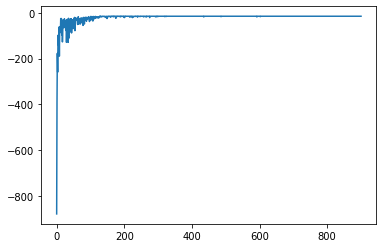

In [8]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

### Cliff World

Let's now see how our algorithm compares against q-learning in case where we force agent to explore all the time.

<img src=https://miro.medium.com/max/2072/1*FBJfEd_cuVW1CsDK7gCQsg.png width=300>
<center><i>image by cs188</i></center>

In [9]:
import gym
import gym.envs.toy_text
env = gym.envs.toy_text.CliffWalkingEnv()
n_actions = env.action_space.n

print(env.__doc__)
# Agent can choose to go as close to the cliff as it wishes. x:start, T:exit, C:cliff, o: flat ground
env.render()


    This is a simple implementation of the Gridworld Cliff
    reinforcement learning task.

    Adapted from Example 6.6 (page 106) from Reinforcement Learning: An Introduction
    by Sutton and Barto:
    http://incompleteideas.net/book/bookdraft2018jan1.pdf

    With inspiration from:
    https://github.com/dennybritz/reinforcement-learning/blob/master/lib/envs/cliff_walking.py

    The board is a 4x12 matrix, with (using Numpy matrix indexing):
        [3, 0] as the start at bottom-left
        [3, 11] as the goal at bottom-right
        [3, 1..10] as the cliff at bottom-center

    Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward
    and a reset to the start. An episode terminates when the agent reaches the goal.
    
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T



In [10]:
def play_and_train(env, agent, t_max=10**4):
    """This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward"""
    total_reward = 0.0
    s = env.reset()

    for t in range(t_max):
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)
        agent.update(s, a, r, next_s)

        s = next_s
        total_reward += r
        if done:
            break

    return total_reward

In [11]:
agent_sarsa = SarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_evsarsa = EVSarsaAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                           get_legal_actions=lambda s: range(n_actions))

agent_ql = QLearningAgent(alpha=0.25, epsilon=0.2, discount=0.99,
                          get_legal_actions=lambda s: range(n_actions))

EVSARSA mean reward = -35.66
QLEARNING mean reward = -97.87


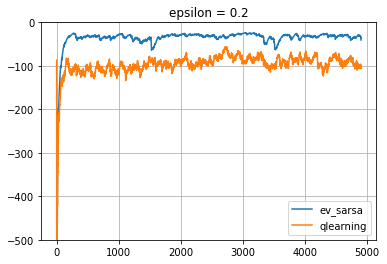

In [12]:
from IPython.display import clear_output
from pandas import DataFrame


def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values


rewards_sarsa, rewards_ql = [], []

for i in range(5000):
    rewards_sarsa.append(play_and_train(env, agent_sarsa))
    rewards_ql.append(play_and_train(env, agent_ql))
    # Note: agent.epsilon stays constant

    if i % 100 == 0:
        clear_output(True)
        print('EVSARSA mean reward =', np.mean(rewards_sarsa[-100:]))
        print('QLEARNING mean reward =', np.mean(rewards_ql[-100:]))
        plt.title("epsilon = %s" % agent_ql.epsilon)
        plt.plot(moving_average(rewards_sarsa), label='ev_sarsa')
        plt.plot(moving_average(rewards_ql), label='qlearning')
        plt.grid()
        plt.legend()
        plt.ylim(-500, 0)
        plt.show()

Let's now see what did the algorithms learn by visualizing their actions at every state.

In [13]:
def draw_policy(env, agent):
    """ Prints CliffWalkingEnv policy with arrows. Hard-coded. """
    n_rows, n_cols = env._cliff.shape

    actions = '^>v<'

    for yi in range(n_rows):
        for xi in range(n_cols):
            if env._cliff[yi, xi]:
                print(" C ", end='')
            elif (yi * n_cols + xi) == env.start_state_index:
                print(" X ", end='')
            elif (yi * n_cols + xi) == n_rows * n_cols - 1:
                print(" T ", end='')
            else:
                print(" %s " %
                      actions[agent.get_best_action(yi * n_cols + xi)], end='')
        print()

In [14]:
print("Q-Learning")
draw_policy(env, agent_ql)

print("SARSA")
draw_policy(env, agent_sarsa)

Q-Learning
 v  >  v  >  v  v  >  v  v  v  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 >  >  >  >  >  >  >  >  >  >  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 
SARSA
 >  >  >  >  >  >  >  >  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  ^  >  >  >  v 
 ^  ^  ^  ^  ^  ^  ^  >  ^  ^  >  v 
 X  C  C  C  C  C  C  C  C  C  C  T 


# Binarized state spaces

Use agent to train efficiently on CartPole-v0.
This environment has a continuous set of possible states, so you will have to group them into bins somehow.

The simplest way is to use `round(x,n_digits)` (or numpy round) to round real number to a given amount of digits.

The tricky part is to get the n_digits right for each state to train effectively.

Note that you don't need to convert state to integers, but to __tuples__ of any kind of values.

Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
first state:[0.02167641 0.03739519 0.01629776 0.0469277 ]


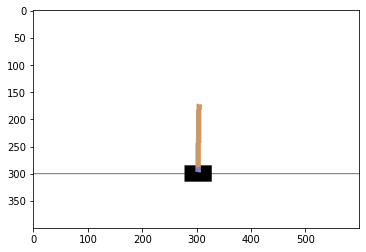

In [15]:
env = gym.make("CartPole-v0")
n_actions = env.action_space.n
print(env.observation_space)
print("first state:%s" % (env.reset()))
plt.imshow(env.render('rgb_array'))

### Play a few games

We need to estimate observation distributions. To do so, we'll play a few games and record all states.

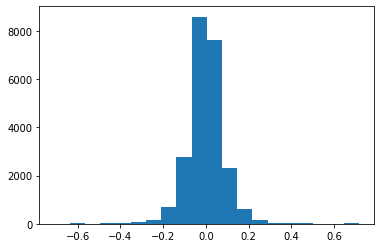

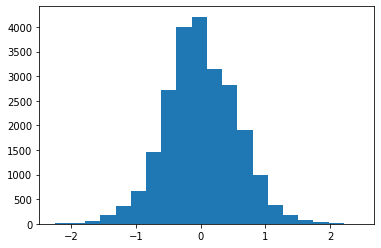

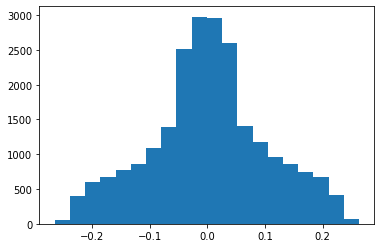

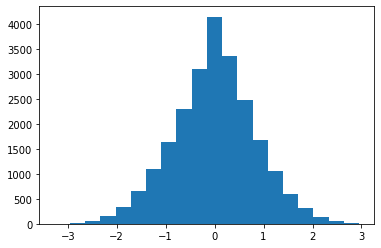

In [16]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):
    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Binarize environment

In [17]:
from gym.core import ObservationWrapper


class Binarizer(ObservationWrapper):

    def observation(self, state):

        # state = <round state to some amount digits.>
        # hint: you can do that with round(x,n_digits)
        # you will need to pick a different n_digits for each dimension
        state[0] = np.round(state[0], 0)
        state[1] = np.round(state[1], 1)
        state[2] = np.round(state[2], 2)
        state[3] = np.round(state[3], 1)

        return tuple(state)

In [18]:
env = Binarizer(gym.make("CartPole-v0"))

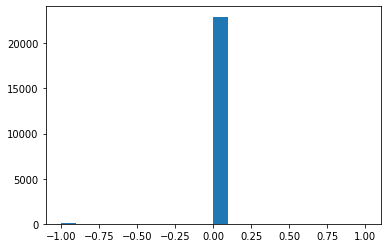

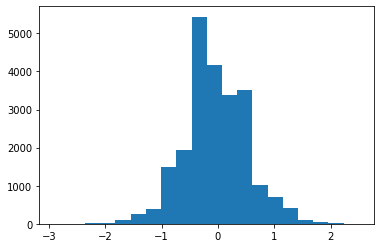

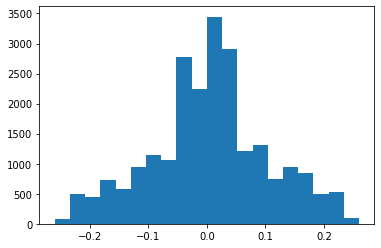

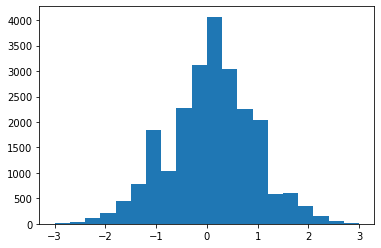

In [19]:
all_states = []
for _ in range(1000):
    all_states.append(env.reset())
    done = False
    while not done:
        s, r, done, _ = env.step(env.action_space.sample())
        all_states.append(s)
        if done:
            break

all_states = np.array(all_states)

for obs_i in range(env.observation_space.shape[0]):

    plt.hist(all_states[:, obs_i], bins=20)
    plt.show()

## Learn binarized policy

Now let's train a policy that uses binarized state space.

__Tips:__ 
* If your binarization is too coarse, your agent may fail to find optimal policy. In that case, change binarization. 
* If your binarization is too fine-grained, your agent will take much longer than 1000 steps to converge. You can either increase number of iterations and decrease epsilon decay or change binarization.
* Having 10^3 ~ 10^4 distinct states is recommended (`len(QLearningAgent._qvalues)`), but not required.
* A reasonable agent should get to an average reward of >=50.

In [20]:
agent = QLearningAgent(alpha=0.5, epsilon=0.25, discount=0.99,
                       get_legal_actions=lambda s: range(n_actions))

eps = 1.1676436783668747e-08 mean reward = 9.3


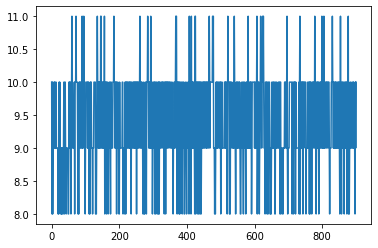

In [21]:
rewards = []
agent.epsilon = 0.0001
for i in range(1000):
    rewards.append(play_and_train(env, agent))

    # OPTIONAL: you can adjust epsilon
    agent.epsilon *= 0.99
    if i % 100 == 0:
        clear_output(True)
        print('eps =', agent.epsilon, 'mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()